#  Activity 1. K-Nearest Neighbour Classifier
### Background
In this activity, we learn how [K-Nearest Neighbors (KNN)](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/) classifier works. KNN is a simple non-parametric model, which is an example of [instance-based](https://en.wikipedia.org/wiki/Instance-based_learning) supervised learning. We use KNN as a vehicle to practice some of the basic concepts of machine learning. KNN is a [lazy learner](https://en.wikipedia.org/wiki/Lazy_learning) that stores all training data points and their labels in memory, and predict the class label for a new data point based on its similarity to the training data (in fact the stored training data points can be considered as parameters).

Consider a training dataset containing (x,t) pairs where $x$ is the input, and $t$ is the target class label. Suppose we have been given a similarity measure $sim(x_1,x_2)$ which gives the similarity score when fed with two data points. Given a test data point $x$, the K-nearest neighbour classifier works as follows:

* Select the top K most similar data points to x from the training set
* Look at the label of the K-nearest neighbours and select the label which has the majority vote.

If the classes are equally common among the neighbours (e.g., two positive and two negative neighbours in binary classification when K=4), the test datapoint is randomly assigned to one of the classes. For example, **Figure A.1** (below) illustrates such situation where the test datapoint (shown by <span style="color: #00ff00;">green</span>) has exactly two neighbours from each class (marked by <span style="color: #ff0000;">red</span> and <span style="color: #3366ff;">blue</span>).

<a href="http://www.saedsayad.com/k_nearest_neighbors.htm" rel="attachment wp-att-92100"><img class="wp-image-92100 size-full" src="https://www.alexandriarepository.org/wp-content/uploads/20160413152921/A.1.png" alt="Figure A.1: KNN for Classification. The green dot indicates a sample with an unknown class label, while red and blue samples are training observation from default and non-default classes, respectively. Source: http://www.saedsayad.com/k_nearest_neighbors.htm" width="497" height="274" /></a> 

> Figure A.1: KNN for Classification. The green dot indicates a sample with an unknown class label, while red and blue samples are training observation from default and non-default classes, respectively. Source: http://www.saedsayad.com/k_nearest_neighbors.htm

### Further Materials
This short <a href="https://www.youtube.com/watch?v=UqYde-LULfs">YouTube video</a> explains KNN and related concepts in a very simple language.

# Steps for Activity 1
<ol>
	<li>Load the iris dataset and divide it to separate training and testing sets,</li>
    <li>Define a function that calculates the majority vote,</li>
    <li>Define KNN function that takes training labeled samples, testing samples, $K$ and a distance metric and predicts the class labels for the testing samples,</li>
	<li>Apply KNN where for some values of $K$ and report training and testing error</li>
	<li>Plot training and testing error versus $1/K$ where $K \in \{1,\cdots,100\}$</li>
</ol>

# Implementation of the Above Steps
Here, we implement a basic KNN classifier. Note that in Assignment 1, you will be asked to expand this implementation and build a KNN regressor. In this task, we use a simple, yet very popular, dataset to investigate the performance of our KNN. 

### Load and Explor Data
Let us start with loading the libraries and dataset.

In [1]:
# load the libs
library(reshape2)
library(ggplot2)
library(corrplot)
library(plyr)

corrplot 0.84 loaded


In [2]:
# Load data: it's built in to R, however, you can also get it online
# iris <- read.csv(url("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"), header = FALSE)
library(datasets)
data(iris)

# take a look at the data
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


As shown there are are 4 measurements (petal & sepal width & length) for 3 species of iris flowers, where sepal is: "One of the usually separate, green parts that surround and protect the flower bud" (or petals)

In [3]:
dim(iris) # 150 x 5 records

[1] 150   5

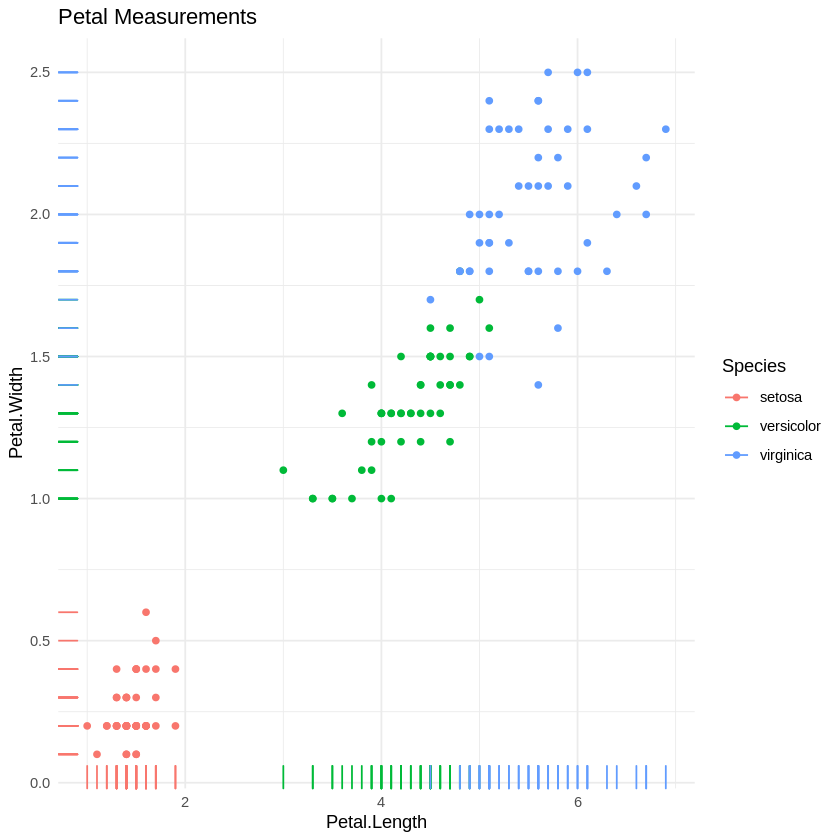

In [4]:
# Some visualizations wont hurt!
## the followin plot illustrates petal measurments:
ggplot(data=iris, aes(x=Petal.Length, y=Petal.Width, color=Species)) +  # plot Width vs Length by Species 
    geom_point() +                # Make it a scatter with points
    geom_rug() +                  # add the lines
    theme_minimal() +             # give it a  theme
    ggtitle("Petal Measurements") # add a title

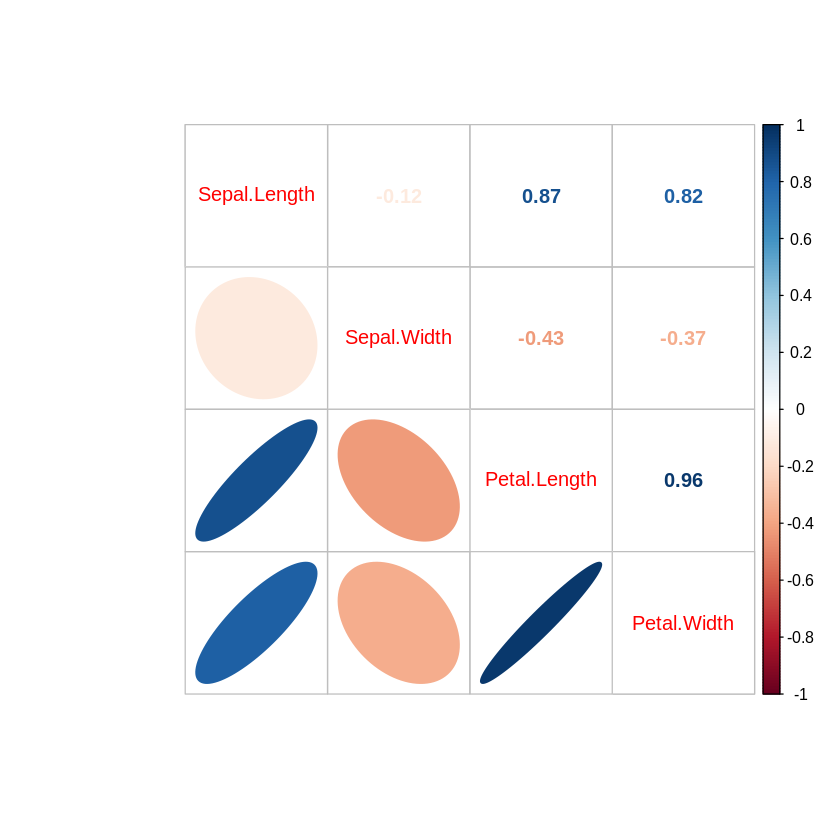

In [5]:
## and this one shows the correlation between the features (input variables)
corrplot.mixed(cor(iris[,-5]), lower="ellipse", upper="number")

### Training and Testing Sets

In [6]:
# set random seed
set.seed(1234)

# permute iris, shuffle or mix them up
# First input to sample requires a vector of numbers i.e. c(1,2,3)..etc. Use 1:nrow(iris) to achieve the same result
# The second argument is sample size so in this case we want to randomly sample everything to effectively shuffle them
iris <- iris[sample(1:nrow(iris),nrow(iris)),]

head(iris) # the shuffled records

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
18,5.1,3.5,1.4,0.3,setosa
93,5.8,2.6,4.0,1.2,versicolor
91,5.5,2.6,4.4,1.2,versicolor
92,6.1,3.0,4.6,1.4,versicolor
126,7.2,3.2,6.0,1.8,virginica
149,6.2,3.4,5.4,2.3,virginica


Notice the number on the left is not in sequential order (the original indices were).

#### Splitting

Splitting is done by setting the training data to the first 100 rows and then creating 2 objects (dataframes) for each of the training and test sets. The first object has all of the measurements being used for KNN and the second has the label reference for Species.

It is important here to recognise that the "iris" object created above has been changed because of the shuffle. Therefore the index numbers that appear in the right hand column of the output are not the same as the actual index numbers. This is because the shuffled dataframe was saved as the same object and has a new index but still shows the old index numbers in the output.


In [7]:
# Create  training and testing subsets:

train.index = 1:100 # first 100 rows as training samples
label.ind = 5       # lables are stored in the last column (5)

train.data <- iris[train.index, -label.ind] # grab the first 100 records, leave out the species (last column)
train.label <- iris[train.index, label.ind]

test.data <- iris[-train.index, -label.ind] # grab the last 50 records, leave out the species (last column)
test.label <- iris[-train.index, label.ind]

dim(train.data) # 100 records
dim(test.data)  # 50 records

[1] 100   4

[1] 50  4

In [8]:
head(train.data) # the first 100 records without the Species

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
,<dbl>,<dbl>,<dbl>,<dbl>
18,5.1,3.5,1.4,0.3
93,5.8,2.6,4.0,1.2
91,5.5,2.6,4.4,1.2
92,6.1,3.0,4.6,1.4
126,7.2,3.2,6.0,1.8
149,6.2,3.4,5.4,2.3


### Majority Vote

The `majority` function takes a list of labels and returns the factor label for the species that occurs the most often in the passed list.

Example: 
* **input:** `x <- train.label[c(1,2,3)]` which is `(setosa,versicolor,versicolor)` - look at the output in the above cell for the actual values
* **output:** `versicolor` because *versiclor* appears 2 times in the first 3 records of the train data 


In [9]:
# define an auxiliary function that calculates the majority votes (or mode!)
## using tabulate
majority <- function(x) {  # Pass the value x which is a dataframe of labels from the K NN values
   
    # grab the unique values for the labels in x
    uniqx <- unique(x)
    
    # Count each unique label that appears and grab the one with the largest values
    uniqx[which.max(tabulate(match(x, uniqx)))]
}

In [10]:
# Alternative approach 
## using plyr
majority_alt <- function(x) {
        
    cnt <- count(x)  # use plyr to create a table of counts by values appearing in x
    
    cnt[which.max(cnt$freq),1]  # simply find the row that has the maximum value in the $freq column created by
                                # the count function but we only want to return the first column with the label
     
}

### KNN Classifier

In [11]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)

knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    ## Combine the test and train sets into a single frame to calculate distances. We want to see for each 
    ## item in the test dataset how far each and every item in the training data set is from those measurements.
    
    ## Therefore, by saving it as a matrix that only includes the test values as rows and the train values as columns
    ## it creates a matrix of test rows where each row includes every training value's distance. Everything is stored
    ## by the index of the data rather than the data itself so it can be looked up in the original datasets
    
    
    dist_data <- rbind(test.data, train.data)  # combine training and test data (order is important)
    
    dist <- dist(dist_data, method= distance)  # calculate the distnaces using the dist function on the combined set
    
    # convert to a matrix but only take some values
    # The first argument for rows is the test rows which were added to the rbind command first and therefore represent
    # the index 1: onwards. To calculate the exact distance we use the length calculated earlier.
    # The second argument represents the columns in the maxtrix which start after the test columns. 
    # Therefore we take test len + 1 to the length of the full training set. 
    # This ensures we only keep test rows x train columns
    
    dist <- as.matrix(dist)[1:test.len, (test.len+1):(test.len+train.len)] 
    
    ## for each test sample...
    for (i in 1:test.len){
        
        ### ...find its K nearest neighbours from training sampels...
        ## Sorting it by i means the shortest distancs are in order, then it is a simple matter of selecting only K 
        ## values and storing those values. Again we store the index for searching rather than actual values. 
        ## The original iris data set was randomly changed at the beginning so the old index displays out of order. 
        ## The actual index referred to here is the new index created and therefore will always return the right values
        
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]  # index.return is what returns the index
        
        ###... and calculate the predicted labels according to the majority vote
        test.label[i]<- (majority(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

<div class="alert alert-info" role="alert">
   An alternative to the loop in the previous cell is to create a vectorized version and apply it at one time. Intrested readers may complete this part...
</div>

In [12]:
# let see what is the prediciton of our knn for test samples when K=4
knn(train.data, train.label, test.data, K=4)

[1] virginica  virginica  setosa     virginica  virginica  versicolor
 [7] versicolor versicolor setosa     virginica  versicolor versicolor
[13] versicolor versicolor versicolor virginica  versicolor versicolor
[19] versicolor versicolor virginica  setosa     versicolor virginica 
[25] virginica  virginica  setosa     setosa     setosa     versicolor
[31] versicolor virginica  setosa     versicolor setosa     versicolor
[37] virginica  setosa     versicolor virginica  versicolor setosa    
[43] virginica  virginica  virginica  versicolor virginica  setosa    
[49] versicolor setosa    
Levels: setosa versicolor virginica

In [13]:
# and a confusion matrix for K = 5
prop.table(table(knn(train.data, train.label, test.data, K=5), test.label))*100

            test.label
             setosa versicolor virginica
  setosa         24          0         0
  versicolor      0         40         2
  virginica       0          2        32

In [14]:
# calculate the train and test missclassification rates for K in 1:100 
# THIS MAY TAKE A FEW MINUTES TO COMPLETE!
miss <- data.frame('K'=1:100, 'train'=rep(0,100), 'test'=rep(0,100))
miss

K,train,test
<int>,<dbl>,<dbl>
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [15]:
# For each value of K, evaluate the output of KNN for the value K that are not equal to train.label or test.label.
# This equates to TRUE/FALSE and therefore can be summed. Taking the proportion of total data creates a %

for (k in 1:100){
    miss[k,'train'] <- sum(knn(train.data, train.label, train.data, K=k) != train.label)/nrow(train.data)*100
    miss[k,'test'] <-  sum(knn(train.data, train.label, test.data, K=k)  != test.label)/nrow(test.data)*100
}

<div class="alert alert-info" role="alert">
   An alternative approach is to use `apply` over the table to calculate each column and avoid the loop. Intrested readers may complete this part...
</div>

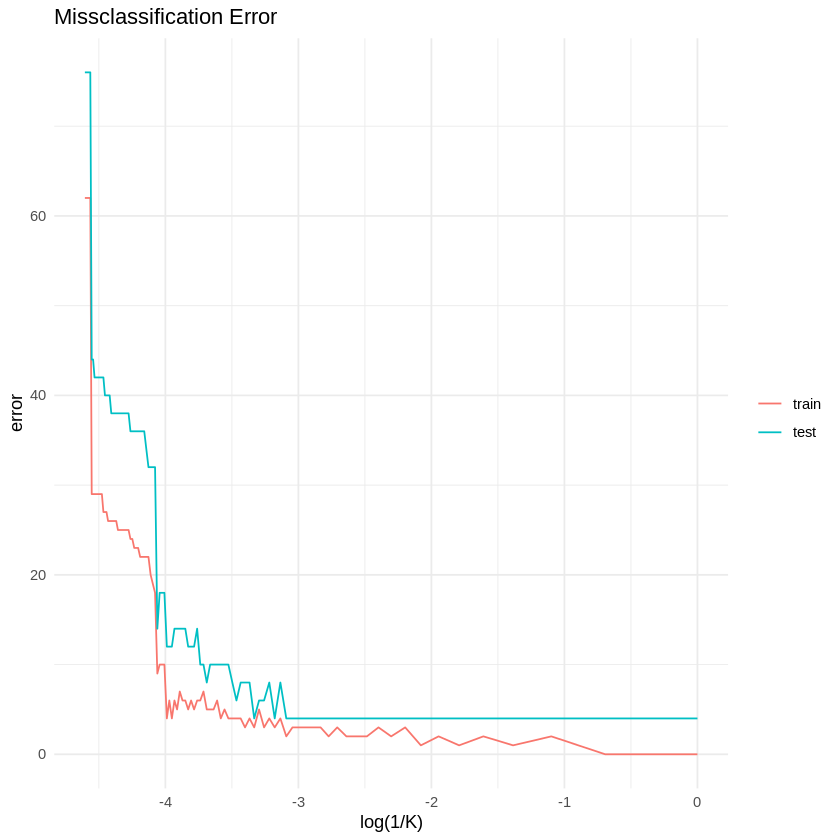

In [16]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id='K') # reshape for visualization
names(miss.m) <- c('K', 'type', 'error')
ggplot(data=miss.m, aes(x=log(1/K), y=error, color=type)) + 
    geom_line() +
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    theme_minimal() +
    ggtitle("Missclassification Error")

<h1>Discussions</h1>
<ol>
	<li>As $K$ increases, does the complexity of the KNN classifier increase or decrease?</li>
	<li>What is the relationship between $1/K$ and the training error?</li>
	<li>What is the relationship between $1/K$ and the testing error?</li>
	<li>How do you explain the difference between training and testing error trends as the complexity of the KNN classifier increases?</li>
    <li>Can you tell the areas where the model overfits and underfits? What is the best value for $K$?</li>
	</ol>